In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import pickle
import os
import numpy as np

mypath = os.getcwd() + '/ready'
files = [''.join([mypath, '/', f]) for f in listdir(mypath) if isfile(join(mypath, f)) ]

### Evaluating Sparsity

Readings are at roughly the second level. We will plot and extract data at that temporal resolution, this can always be altered if we get denser reading intervals

In [3]:
def to_sxs(time):
    return round(time, 0)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def clean_file_name(f):
    return f.replace(f'{os.getcwd()}/ready/', '').replace('.csv.pkl', '').replace('.', '')

In [4]:
#TODO: I think we might have to get more exact about time alignment observations but for now

scam = np.load('/Users/lauren/marinetti/ready/SCam3_tt.csv.pkl', allow_pickle=True)
scam = np.squeeze(scam)

scam_micro  = list(map(to_sxs, scam))

scam_micro = list(map(lambda x: x - to_sxs(min(scam)), scam_micro))

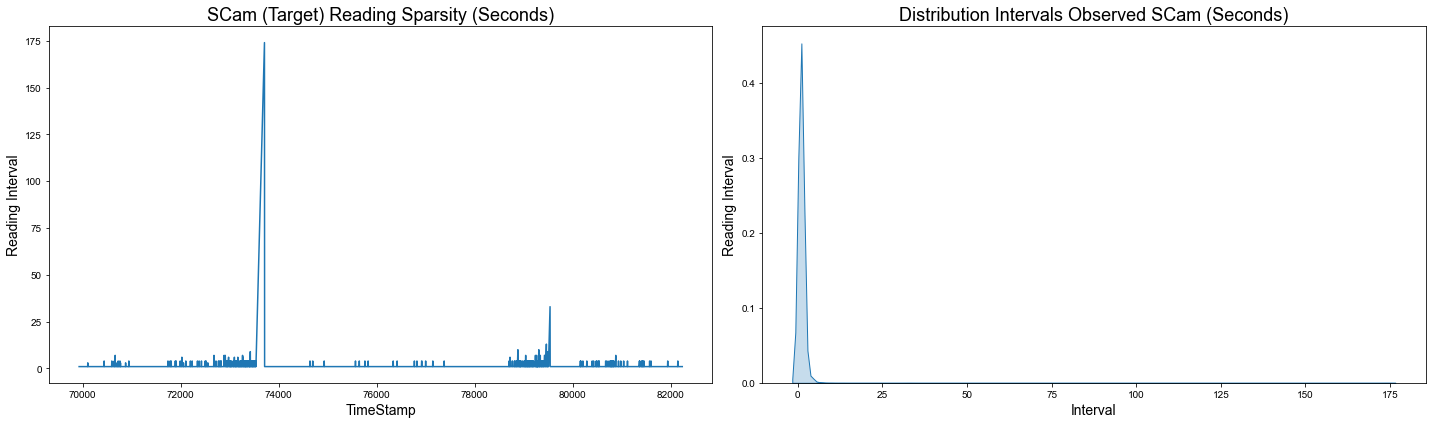

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#load SCam Data
scam_diffs = np.diff(scam_micro)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

ax1.plot(scam[1:], scam_diffs) 
ax1.set_title(label = "SCam (Target) Reading Sparsity (Seconds)", fontdict = { 'fontsize': 18})
ax1.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
ax1.set_xlabel("TimeStamp", fontdict = { 'fontsize': 14})

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as stats
import math

sns.set_style('whitegrid')
p = sns.kdeplot(np.array(scam_diffs), bw_method=0.5, fill=True, ax=ax2)
p.set_title(label='Distribution Intervals Observed SCam (Seconds)', fontdict = { 'fontsize': 18})
p.set_ylabel("Reading Interval", fontdict = { 'fontsize': 14})
p.set_xlabel("Interval", fontdict = { 'fontsize': 14})

plt.tight_layout()

### ETL: ML-Ready Data
For now, we want to create a dataframe as well as raw data for model training with NAN values for the missing interval readings. This lets us train naive models by dropping NAN, it also leaves the door open for more sophisticated models that handle sensor reading sparsity

In [6]:
names = []
              
FLAT_NAMES = ['xCentroid', 'xrms', 'yCentroid', 'yrms', 'uCentroid', 'urms', 'vCentroid', 'vrms', 'Gaussian_Sum']

observations = []
files = [file for file in files if 'tt' not in file.replace('marinetti', '').lower()]
for file_name in files: 
    x = np.load(file_name, allow_pickle=True)
    if x.shape[0]: #some are 0
        if x.shape[1] > 1:
            flatten = np.split(x, x.shape[1], axis =1)
            for j, f in enumerate(flatten):
                expand_name = clean_file_name(file_name) + '_'+ FLAT_NAMES[j]
                names.append(expand_name)
                observations.append(f)
        else:
            names.append(clean_file_name(file_name))
            observations.append(x)
            
observations = np.concatenate(observations, axis = 1)

### Make DataFrame

Make the correct datetime intervals by doing a join on a dataframe with dense readings and the one constructed from the actual readings 

In [7]:
#scam micro is normalized to start at 0 
rx = list(range(0, int(max(scam_micro))))
tf = pd.DataFrame({'year': [1970] * len(rx),
                   'month': [1] * len(rx),
                   'day': [1] * len(rx),
                   'seconds': len(rx)})



i = pd.date_range(0, periods=len(rx), freq='S')
left_df = pd.DataFrame(columns = names, index = i)

In [8]:
s = pd.to_datetime(scam_micro, unit='s')
right_df = pd.DataFrame(observations, columns = names, index=s)

In [9]:
#pandas.merge_asof nifty thing if we want to do approximate matching
right_df.index.name = 'Time'
left_df.index.name = 'Time'

joined = right_df.join(left_df, how='right', rsuffix='Time')

joined  = joined.iloc[:, 0:48]

# Basic Visualization

#### Control Parameters

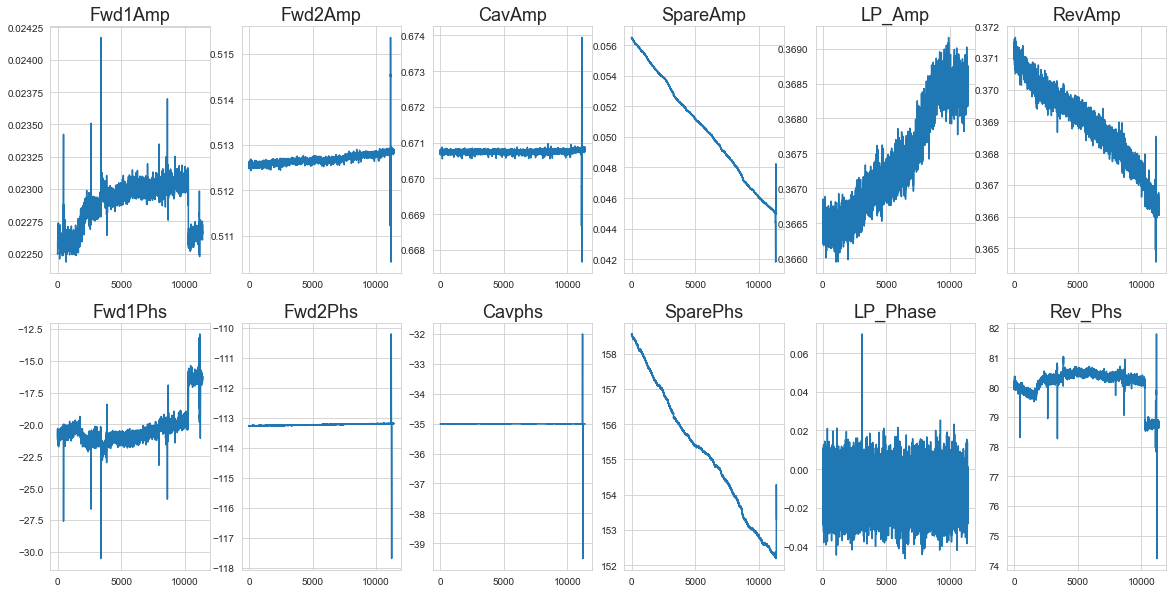

In [10]:
#by device 
fwd1 = ['Fwd1Amp', 'Fwd1Phs']
fwd2 = ['Fwd2Amp', 'Fwd2Phs']
cav = ['CavAmp', 'Cavphs']
spare = ['SpareAmp', 'SparePhs']
lp = ['LP_Amp', 'LP_Phase']
rev = ['RevAmp', 'Rev_Phs']

amps = ['Fwd1Amp',  'Fwd2Amp', 'CavAmp', 'SpareAmp', 'LP_Amp','RevAmp']
phs =  ['Fwd1Phs', 'Fwd2Phs', 'Cavphs', 'SparePhs',  'LP_Phase', 'Rev_Phs']

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 10))


for i in range(0, len(amps)):
    t = np.array(range(0, 11389))
    y = np.array(np.squeeze(joined[amps[i]].dropna()))
    axes[0, i].plot(t, y)
    axes[0, i].set_title(label = f"{amps[i]}", fontdict = { 'fontsize': 18})

for i in range(0, len(phs)):
    t = np.array(range(0, 11389))
    y = np.array(np.squeeze(joined[phs[i]].dropna()))
    axes[1, i].plot(t, y)
    axes[1, i].set_title(label = f"{phs[i]}", fontdict = { 'fontsize': 18})



### LCam Data
#### Histogram Centroids

In [11]:
lcam_bg_loc_data = ['LCamGaussBG_xCentroid', 'LCamGaussBG_xrms',  'LCamGaussBG_yCentroid', 'LCamGaussBG_uCentroid', 'LCamGaussBG_vCentroid']
 
lcam_loc_data = ['LCamGauss_xCentroid', 'LCamGauss_xrms', 'LCamGauss_yCentroid', 'LCamGauss_uCentroid', 'LCamGauss_vCentroid']
    
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
# joined[lcam_bg_loc_data + lcam_loc_data].plot(subplots=True, ax= axes)


def camera_plot(camera_type):
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
    for i, coord in enumerate(['x', 'y', 'u', 'v']):
        # Load an example dataset with long-form data
        mean_bg= np.array(np.squeeze(joined[[f'{camera_type}GaussBG_{coord}Centroid']].dropna()))
        std_bg = np.array(np.squeeze(joined[[f'{camera_type}GaussBG_{coord}rms']].dropna()))
        t = np.array(range(0, 11389))

        mean= np.array(np.squeeze(joined[[f'{camera_type}Gauss_{coord}Centroid']].dropna()))
        std = np.array(np.squeeze(joined[[f'{camera_type}Gauss_{coord}rms']].dropna()))
        t = np.array(range(0, 11389))


        n_mean = mean - mean_bg
        n_std = std - std_bg

        print(f'Normalized mean is {np.sum(n_mean)} and normalized std {n_std} for camera {camera_type}')
        
#         if np.sum(n_mean) != 0.0:
#             ax[i].plot(t, mean_bg, label='X Centroid')
#             ax[i].fill_between(t, mean_bg - std_bg, mean_bg + std_bg, alpha=1.0)
        ax[i].plot(t, mean, label='X Centroid')
        ax[i].fill_between(t, mean - std, mean + std, alpha=1.0, color="blue")
    return ax 

Normalized mean is -1041852.0 and normalized std [0. 0. 0. ... 0. 0. 0.] for camera SCam3_
Normalized mean is -39564.0 and normalized std [0. 0. 0. ... 0. 0. 0.] for camera SCam3_
Normalized mean is 0.0 and normalized std [0. 0. 0. ... 0. 0. 0.] for camera SCam3_
Normalized mean is 0.0 and normalized std [0. 0. 0. ... 0. 0. 0.] for camera SCam3_


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

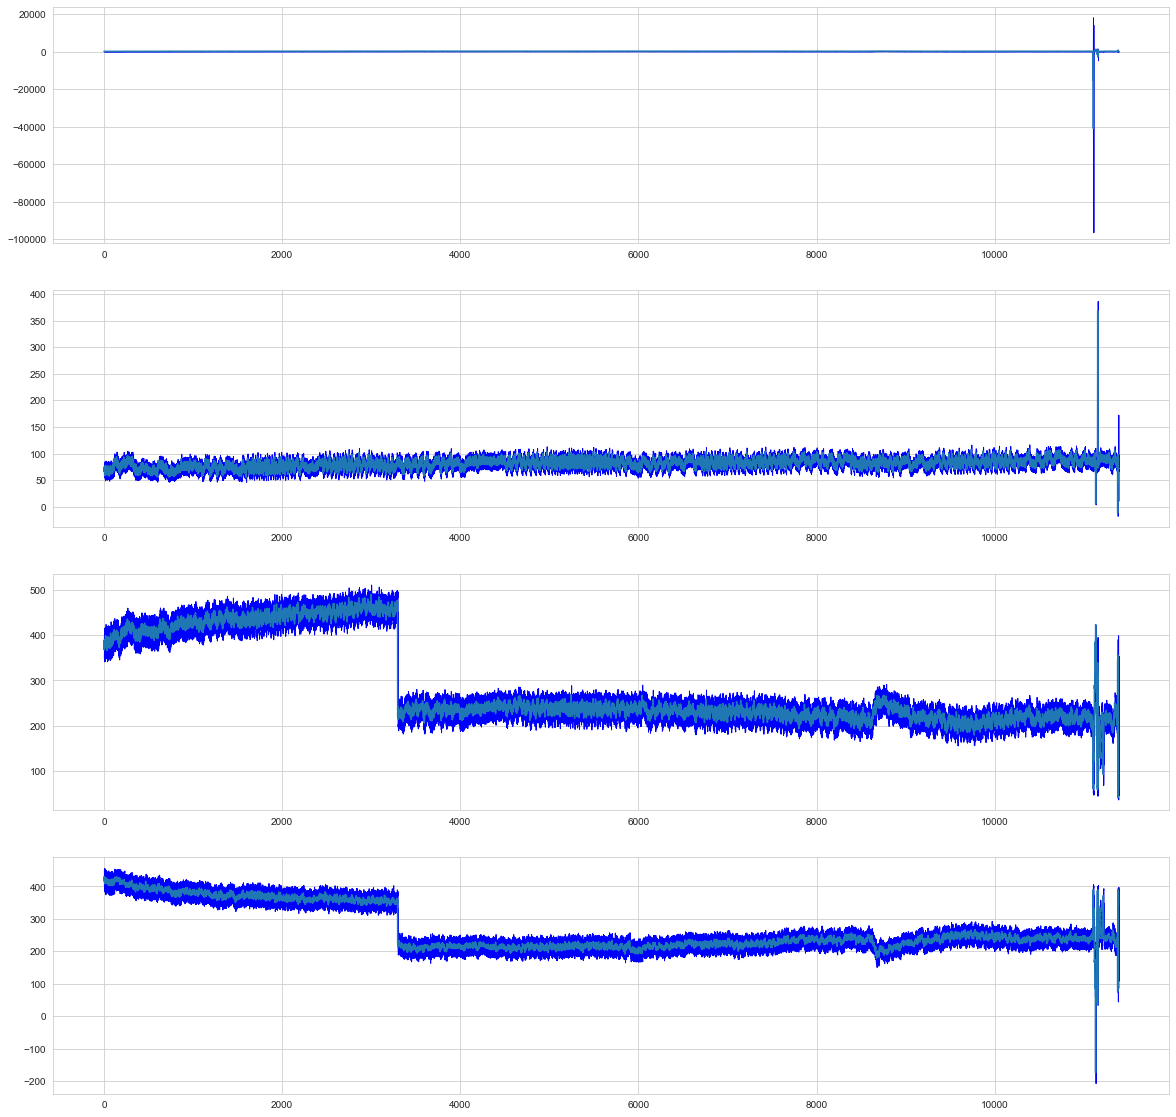

In [13]:
camera_plot("SCam3_")

In [262]:
len(joined.dropna().index)

11389

In [260]:
joined.to_pickle('pickled_df_ALL.pk')

In [225]:
joined.head()

,Fwd1Amp,LCamGaussBG_xCentroid,LCamGaussBG_xrms,LCamGaussBG_yCentroid,LCamGaussBG_yrms,LCamGaussBG_uCentroid,LCamGaussBG_urms,LCamGaussBG_vCentroid,LCamGaussBG_vrms,LCamGaussBG_Gaussian_Sum,...,LCamGaussBG_yrmsTime,LCamGaussBG_uCentroidTime,LCamGaussBG_urmsTime,LCamGaussBG_vCentroidTime,LCamGaussBG_vrmsTime,LCamGaussBG_Gaussian_SumTime,Fwd1PhsTime,CavAmpTime,SpareAmpTime,CavphsTime
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00,0.022508,32.003670,8.270485,42.817985,8.089002,43.040927,8.848505,46.787501,7.987521,235214.116828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:01,0.022537,31.682232,7.919545,42.790500,8.070923,42.555308,8.244010,46.976442,7.834073,134689.852673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:02,0.022541,32.003254,8.434171,42.783151,8.257484,43.060566,8.999335,46.862217,8.029195,271305.418341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:03,0.022562,31.844320,8.549102,42.984730,8.491756,43.214291,9.033780,47.377427,8.326892,270607.890889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:04,0.022517,31.892984,8.352428,42.924966,8.361304,43.355929,8.901612,47.063289,8.280108,279649.641176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create Manifest

In [ ]:
import csv

intervals = set(intervals)
scam = set(map(lambda x: math.floor(x), scam))

null_intervals = intervals.difference(scam)

with open(f'data/manifest.json', 'w') as outfile:
    records = []
    
    for interval in intervals:
        data = f"{interval}.csv" if interval not in null_intervals else None
        records.append({'obs': interval , 'data': data})
    json.dump(records, outfile)

observations = np.squeeze(observations)
scam = set(map(lambda x: math.floor(x), scam))

for i, sc in enumerate(scam):
    with open(f'data/{sc}.csv', 'w') as f:

        # using csv.writer method from CSV package
        write = csv.writer(f)

        write.writerow(observations[:, i])


In [ ]:
import json
f = open(f'data/manifest.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
assert len(intervals) == len(data)
assert set(map(lambda x: x['obs'], data)) == set(intervals)

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("data/") if 'csv' in f]

files_that_should = []
for o in data:
    if o['data']:
        files_that_should.append(str(o['obs']) + '.csv')
print(f"Size of Manifest Files {len(files_that_should)} and size of actual files {len(onlyfiles)}")
print(f"Ex. Element Manifest {files_that_should[0]} Ex. Element Actual {onlyfiles[0]}")

assert set(files_that_should) == set(onlyfiles)